In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

class GromacsITPFile(object):
    def __init__(self, filename):
        self.filename = filename
    def read_residue(self, residue_name):
        colnames = {"atoms" : "id type resnr residue atom cgnr charge".split(),
                   "bonds": "i  j 	funct 	length 	force.c.".split(),
                   "angles": "i  j  k 	funct 	angle 	force.c.".split(),
                   "molname": "molname       nrexcl".split()}
        tables = {}
        with open(self.filename, "r") as file_handle:
            sectionline = 0
            in_table = False
            correct_section = False
            for line in file_handle:
                stripline = line.strip()
                if len(stripline) > 0:
                    if stripline[0] == "[" and stripline[-1] == "]":
                        table_name = stripline[1:-1].strip()
                        sectionline = 0
                        in_table = True
                        if table_name in colnames:
                            table_columns = colnames[table_name]
                        else:
                            table_columns = None
                    elif line[0] == ";" and sectionline == 1:
                        pass
                        #table_columns = line[1:].split()
                    elif in_table:
                        if table_name == "moleculetype":
                            if stripline.split()[0] == residue_name:
                                correct_section = True
                            else:
                                correct_section = False
                        if table_name in ["atoms", "bonds", "angles"] and correct_section:
                            if table_name not in tables:
                                tables[table_name] = []
                            tables[table_name].append({key: value for key, value in zip(table_columns, stripline.split())})
                        
                sectionline += 1
        rp = ResidueParameters(residue_name)
        for atom in tables["atoms"]:
            rp.add_atom(atom["id"], atom)
        for bond in tables["bonds"]:
            rp.add_bond(bond["i"], bond["j"], bond)
        for angle in tables["angles"]:
            rp.add_angle(angle["i"], angle["j"], angle["k"], angle)
        return rp

In [10]:
class RPAtom(object):
    def __init__(self, attrs):
        self.attrs = attrs
        self.i_bonded = []
        self.j_bonded = []
        self.i_angled = []
        self.j_angled = []
        self.k_angled = []
    def bonded(self):
        ba = []
        for bond in self.i_bonded:
            ba.append(bond.j_atom)
        for bond in self.j_bonded:
            ba.append(bond.i_atom)
        return ba
    def bonded_ids(self):
        return [x.attrs["id"] for x in self.bonded()]

class RPBond(object):
    def __init__(self, i_atom, j_atom, attrs):
        i_atom.i_bonded.append(self)
        j_atom.j_bonded.append(self)
        self.attrs = attrs
        self.i_atom = i_atom
        self.j_atom = j_atom

class RPAngle(object):
    def __init__(self, i_atom, j_atom, k_atom, attrs):
        i_atom.i_angled.append(self)
        j_atom.j_angled.append(self)
        k_atom.k_angled.append(self)
        self.attrs = attrs
        self.i_atom = i_atom
        self.j_atom = j_atom
        self.k_atom = k_atom
        self._graph = None
class ResidueParameters(object):
    def __init__(self, resname):
        self.resname = resname
        self.atoms = {}
        self.bonds = []
        self.angles = []
        self._graph = None
    def add_atom(self, id, attributes):
        self.atoms[id] = RPAtom(attributes)
    def add_bond(self, i, j, attributes):
        i_atom = self.atoms[i]
        j_atom = self.atoms[j]
        self.bonds.append(RPBond(i_atom, j_atom, attributes))
    def add_angle(self, i, j, k, attributes):
        i_atom = self.atoms[i]
        j_atom = self.atoms[j]
        k_atom = self.atoms[k]
        self.angles.append(RPAngle(i_atom, j_atom, k_atom, attributes))
    def bonded_ids(self, atom_id):
        return self.atoms[atom_id].bonded_ids()
    def graph(self):
        if self._graph is None:
            g = nx.Graph()
            atoms = self.atoms.keys()
            g.add_nodes_from(self.atoms.keys())
            for atom in atoms:
                for other in self.bonded_ids(atom):
                    g.add_edge(atom, other)
            self._graph = g
        return self._graph
    def mcs(self, other, threshold=0.9):
        # Start with dictionaries of atoms and what type they're connected to:
        from_atoms = {
            k:(
                atom.attrs["type"], 
                [x.attrs["type"] for x in atom.bonded()]
            ) for k, atom in self.atoms.items()
        }
        to_atoms = {
            k:(
                atom.attrs["type"], 
                [x.attrs["type"] for x in atom.bonded()]
            ) for k, atom in other.atoms.items()
        }
        # These will hold our maps as they're grown
        grow_maps = list()
        done_maps = list()
        # Find common subgraphs to start from (of size >= 3)
        # Iterate over pairs of from atoms and to atoms:
        for from_atom_id, (from_atom_type, from_connected_types) in from_atoms.items():
            for to_atom_id, (to_atom_type, to_connected_types) in to_atoms.items():
                if martini_type_similarity(from_atom_type, to_atom_type) > 0.5:
                    # Atom types are similar
                    candidate_map = {from_atom_id:to_atom_id}
                    connected_similarity = 0
                    # Sum up compatible connected nodes
                    for fc_type, tc_type in product(from_connected_types, to_connected_types):
                        similarity = martini_type_similarity(fc_type, tc_type)
                        connected_similarity += similarity                           
                    if connected_similarity > 1:
                        # If total is greater than 1, add it to the queue
                        grow_maps.append(candidate_map)
        iters = 0
        while len(grow_maps) > 0 and iters < 1000:
            # Prevent possible while loop explosion
            iters += 1
            # Pop next map from front of queue
            a_b_map = grow_maps.pop(0)
            grown = False
            # Compute reverse map
            b_a_map = {v:k for k, v in a_b_map.items()}
            # Try to grow from each atom
            for a_atom, b_atom in a_b_map.items():
                # Find bonded atoms not already in the map
                a_bonded_atoms = [atom for atom in self.atoms[a_atom].bonded() 
                            if atom.attrs["id"] not in a_b_map]
                b_bonded_atoms = [atom for atom in other.atoms[b_atom].bonded() 
                            if atom.attrs["id"] not in b_a_map]
                # Iterate over all pairs of atoms bonded to atoms in our two molecules
                for a_bonded_atom in a_bonded_atoms:
                    for b_bonded_atom in b_bonded_atoms:
                        # Check if similar
                        if martini_type_similarity(a_bonded_atom.attrs["type"], b_bonded_atom.attrs["type"]) > 0.5:
                            # Copy the dictionary
                            new_map = {x:y for x, y in a_b_map.items()}
                            # Add to the copied dictionary
                            new_map[a_bonded_atom.attrs["id"]] = b_bonded_atom.attrs["id"]
                            # Add unless it's already there
                            if new_map not in grow_maps:
                                grow_maps.append(new_map)
                            grown = True
            # Graph could not be grown further, add to completed list
            if not grown and a_b_map not in done_maps:
                done_maps.append(a_b_map)
                # Control list size - remove smaller graphs
                if len(done_maps) > 1000:
                    done_maps = sorted(done_maps, key=lambda x : -len(x))[:1000]
        sorted_maps = sorted(done_maps, key=lambda x : -len(x))
        longest = sorted_maps[0]
        return [candidate for candidate in sorted_maps if len(candidate) >= len(longest) * threshold]
    def centre_node(self):
        return [x[0] for x in sorted(nx.eccentricity(self.graph()).items(), key=lambda x : x[1])][0]
    def path_to_centre(self, node):
        print(node, self.centre_node())
        return nx.shortest_path(self.graph(), source=node, target=self.centre_node())
    def eccentricity(self, **kwargs):
        return nx.eccentricity(self.graph(), **kwargs)
    def find_lipid_tails(self):
        tail_components = ["C1","C3"]
        graph = self.graph()
        sgs = nx.connected_component_subgraphs(graph.subgraph(
                [x for x,a in self.atoms.items() if a.attrs["type"] in tail_components]
            ))
        sgs = [x.nodes() for x in sgs]
        for subgraph in sgs:
            print [len(self.path_to_centre(x)) for x in subgraph]
        return sgs
    def draw(self, default_colour="white", **colours):
        plt.figure(figsize=(12,12))
        plt.axis('equal')
        g   = self.graph()
        pos = nx.spring_layout(g)
        colour_specified = set([x for y in colours.values() for x in y])
        colours[default_colour] = set(self.atoms.keys()) - colour_specified
        for colour_name, atom_set in colours.items():
            nx.draw_networkx_nodes(g,pos,
                       nodelist=atom_set,
                       node_color=colour_name,
                       node_size=600,
                   alpha=1)
        nx.draw_networkx_edges(g, pos, width=15,alpha=0.5,edge_color='k')
        nx.draw_networkx_labels(g,pos,{k: v.attrs["atom"] for k,v in self.atoms.items()},font_size=8)
        plt.show()
cdl.find_lipid_tails()

('24', '1')


TypeError: object of type 'NoneType' has no len()

In [7]:
dlpg_itp = GromacsITPFile("data/DLPG.itp")
dlpg = dlpg_itp.read_residue("DLPG")
dvpe_itp = GromacsITPFile("data/DVPE.itp")
dvpe = dvpe_itp.read_residue("DVPE")
cdl_itp = GromacsITPFile("data/CDL.itp")
cdl = cdl_itp.read_residue("CDL0")

m = dvpe.mcs(cdl,0.8)
cdl.draw(red=m[0].values(), yellow=m[1].values())

NameError: global name 'plt' is not defined

In [6]:
from itertools import product
import networkx as nx

def martini_type_similarity(type1, type2):
    if type1 == type2:
        return 1
    else:
        differences = {
            "C1.C3" : 0.6,
            "P4.P5" : 0.6
        }
        return getattr(differences, ".".join(sorted([type1, type2])), 0)

class ExchangeMap(object):
    def __init__(self):
        self.from_resname = ""
        self.from_count = 0
        self.to_resname = ""
        self.to_count = 0
        self.actions = []
        self.methods_implemented = ["direct_overlay", "fragment_align", "molecule_align", "simple_bridge", "distort"]
    def used_actions(self):
        return set([x["method"] for x in self.actions])
    def scorecard(self):
        sc = ""
        ua = self.used_actions()
        for m in self.methods_implemented:
            if m in ua:
                sc += "☑"
            else:
                sc += "☐"
        return sc
    def _new_map_fragment_alignment(self, remaining, mapped):
        to_g = self.to_itp.graph()
        remaining_g = to_g.subgraph(remaining)
        fragment_subgraphs = nx.connected_component_subgraphs(remaining_g)
        fragments = []
        for fragment_subgraph in fragment_subgraphs:
            fragment = {"method":"fragment_align"}
            fragment["nodes"] = fragment_subgraph.nodes()
            connected = list()
            for node in fragment["nodes"]:
                c_nodes = to_g.neighbors(node)
                for c_node in c_nodes:
                    if c_node in mapped:
                        connected.append(c_node)
            while len(connected) < 3:
                cc_nodes = set()
                for c_node in connected:
                    cc_nodes.update(set(to_g.neighbors(c_node)))
                cc_nodes = list(set(cc_nodes).intersection(mapped) - set(connected))
                connected += cc_nodes[:3 - len(connected)]
            fragment["reference"] = connected
            fragment["centroid_weighting"] = [1,0,0]
            fragments.append(fragment)
        return fragments
    def _new_map_distort_lipid_tails(self):
        # First find lipid tails
        to_tails = self.to_itp.find_lipid_tails()
        from_tails = self.from_itp.find_lipid_tails()
        if self.from_count > 1:
            from_tails = [
                        [    atom_id+"."+str(i+1) 
                         for atom_id in tail_atoms
                        ] 
                    for i in range(self.from_count) 
                for tail_atoms in from_tails
            ]
        
    def _new_martini_lipid(self, draw=False):
        direct_overlay = self.from_itp.mcs(self.to_itp)[0]
        # These atoms can be directly replaced
        aligned = set(direct_overlay.values())
        remaining = set(self.to_itp.atoms.keys()) - aligned
        fragments = self._new_map_fragment_alignment(remaining, aligned)
        self.actions = [{"method":"direct_overlay", "map" : direct_overlay}] + fragments
        self._new_map_distort_lipid_tails()
    def _new_martini_lipid_to_card(self, draw=False):
        card  = self.to_itp
        lipid = self.from_itp
        # There should be two clear analogues of lipid within card
        candidates = lipid.mcs(card, threshold=0.7)
        card_lipid_1 = candidates[0]
        candidates = [x for x in candidates if 
                      len(set(x.values()).intersection(set(card_lipid_1.values()))
                         ) == 0]
        card_lipid_2 = candidates[0]
        lipid_card_1 = {v:k for k, v in card_lipid_1.items()}
        lipid_card_2 = {v:k for k, v in card_lipid_2.items()}
        if draw:
            print("Find two lipid motifs in cardiolipin:")
            card.draw(orange=card_lipid_1.values(), cyan=card_lipid_2.values())
        card_g = card.graph()
        most_central = [x[0] for x in sorted(nx.eccentricity(card_g).items(), key=lambda x : x[1])]
        if draw:
            print("Find central nodes of cardiolipin:")
            card.draw(
                red=most_central[0], 
                orange=most_central[1:3], 
                yellow=most_central[3:5],
                green=most_central[5:9],
                blue=most_central[5:-8]
            )
        lipid_1_bridge = [x for x in most_central if x in card_lipid_1.values()][0]
        lipid_2_bridge = [x for x in most_central if x in card_lipid_2.values()][0]
        bridge = nx.shortest_path(card_g, lipid_1_bridge, lipid_2_bridge)
        if draw:
            card.draw(orange=[lipid_1_bridge], cyan=[lipid_2_bridge], yellow=bridge[1:-1])
        combined_map = {k:v for k,v in [("2."+x[0],x[1]) for x in card_lipid_2.items()] + [("1."+x[0],x[1]) for x in card_lipid_1.items()]}
        self.actions = []
        self.actions.append({
                "method"   : "simple_bridge",
                "from"  : "1." + str(lipid_card_1[lipid_1_bridge]),
                "to"    : "2." + str(lipid_card_2[lipid_2_bridge]),
                "atoms" : bridge
            })
        self.actions.append({
                "method"  : "direct_overlay",
                "map"    : combined_map
            })
        remaining = [x for x in card.atoms if x not in combined_map.values() and x not in bridge]
        remaining_g = card_g.subgraph(remaining)
        self.actions += self._new_map_fragment_alignment(remaining, combined_map.values() + bridge)
        self._new_map_distort_lipid_tails()
        #print(remaining)
        #print(self)
    def __repr__(self):
        return " 〘 ⚗ Change {from_count}x {from_resname} to {to_count}x {to_resname} {sc} 〙 ".format(sc=self.scorecard(), **self.__dict__)
    def new(self, from_itp=None, to_itp=None, method="martini.lipid", draw=False):
        self.from_itp = from_itp
        self.to_itp = to_itp
        self.from_resname = self.from_itp.atoms.values()[0].attrs["residue"]
        self.from_count = 1
        self.to_resname = self.to_itp.atoms.values()[0].attrs["residue"]
        self.to_count = 1
        if method == "martini.lipid":
            return self._new_martini_lipid(draw=draw)
        if method == "martini.lipid_to_card":
            self.from_count = 2
            return self._new_martini_lipid_to_card(draw=draw)
            
x = ExchangeMap()
x.new(from_itp=dlpg, to_itp=cdl, method="martini.lipid_to_card", draw=False)
y = ExchangeMap()
#y.new(from_itp=dlpg, to_itp=dvpe, method="martini.lipid", draw=False)
x
#cdl.draw(red=["25","26","27"], blue=["24","23","17"])

('24', '1')


TypeError: object of type 'NoneType' has no len()

In [116]:
nx.degree_centrality(cdl.graph())

{'1': 0.07692307692307693,
 '10': 0.07692307692307693,
 '11': 0.07692307692307693,
 '12': 0.07692307692307693,
 '13': 0.07692307692307693,
 '14': 0.038461538461538464,
 '15': 0.07692307692307693,
 '16': 0.11538461538461539,
 '17': 0.07692307692307693,
 '18': 0.07692307692307693,
 '19': 0.07692307692307693,
 '2': 0.07692307692307693,
 '20': 0.07692307692307693,
 '21': 0.07692307692307693,
 '22': 0.038461538461538464,
 '23': 0.07692307692307693,
 '24': 0.07692307692307693,
 '25': 0.07692307692307693,
 '26': 0.07692307692307693,
 '27': 0.038461538461538464,
 '3': 0.11538461538461539,
 '4': 0.07692307692307693,
 '5': 0.07692307692307693,
 '6': 0.07692307692307693,
 '7': 0.07692307692307693,
 '8': 0.07692307692307693,
 '9': 0.038461538461538464}

In [164]:
dlpg_itp = GromacsITPFile("data/DLPG.itp")
dlpg = dlpg_itp.read_residue("DLPG")
cer_itp = GromacsITPFile("data/martini_v2.0_CER.itp")
cer = cer_itp.read_residue("CER")

In [160]:
x = ExchangeMap(from_residue="DLPG", to_residue="DVPE")
x.new(from_itp=dlpg, to_itp=dvpe)

[{'map': {'2': '2',
   '3': '3',
   '4': '4',
   '5': '5',
   '6': '6',
   '8': '9',
   '9': '10'},
  'method': 'direct_overlay'},
 {'method': 'fragment_align',
  'nodes': ['11', '12'],
  'reference': ['10', '9', '4']},
 {'method': 'fragment_align', 'nodes': ['1'], 'reference': ['2', '3', '5']},
 {'method': 'fragment_align',
  'nodes': ['8', '7'],
  'reference': ['6', '5', '3']}]

In [43]:
a.add_node(1)
a.add_node(2)
a.add_edge(1,2)

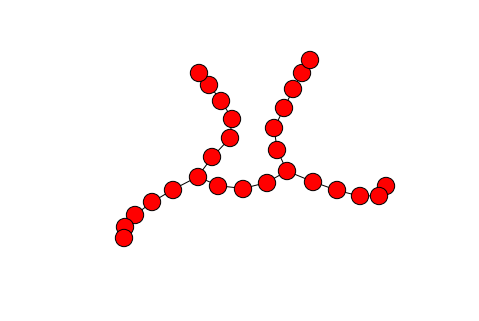

In [47]:

nx.draw(cdl.graph())
plt.show()